# LightGBM - Default Model

In [1]:
# General libraries
import json
import time
import math
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt 

# Preprocessing
from utils import preprocessing as prep

# Modelling
import optuna
import lightgbm as lgb 
from lightgbm import LGBMRegressor
from optuna.samplers import TPESampler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score, train_test_split, cross_val_score, KFold, cross_val_predict
from sklearn.metrics import mean_absolute_error, r2_score, make_scorer, mean_squared_error

## 1. Load Data

Load the 1 year of data and apply some additional preprocessing steps that were not handled in the 1-week preprocessing

In [2]:
large_df = pd.read_csv(r"C:\Users\Gebruiker\Documents\CODE\Master\Thesis\Local_Testing\large_preprocessed_week_24-05-2024.csv", low_memory = False) 

In [3]:
df = large_df.copy()

# remove trains that leave more than 3 minutes too late or early
df =  df[df["DIFF_TURNOVER_TIME"].between(-180, 180)]

# remove trains that have more than 2500s turnover time
df = df[(df["REALIZED_TURNOVER_TIME"] <= 2500) & (df["REALIZED_TURNOVER_TIME"] >= 120)]
df = df[df["PLAN_TURNOVER_TIME"] >= 120]

# Add 3 minutes delay boundary
df = df[(df["DELAY"] <= 180) & (df["DELAY"] >= -180)]

# Keep only 40 largest stations in turnover count
top_40_stations = df['STATION'].value_counts().nlargest(10)
top_40_station_names = top_40_stations.index.tolist()
df = df[df["STATION"].isin(top_40_station_names)]

# Remove large negative signal delays
df = df.loc[df["PLAN_SIGNAL_SAFE_DELAY"] > -180]

# Remove distance outliers
df = df.loc[df["CUM_DISTANCE_M"] <= 300000]

# Remove short arrivals 'K_V'
df = df[df["ACTIVITYTYPE"] == "V"]

# Remove obscure directions
df = df[df["TRAINSERIE_DIRECTION"].isin(["E", "O"])]

# Remove num_carriages which rarely occured
df = df[df["NUMBER_CARRIAGES"] <= 10]

Remove columns irrelevant for modelling

In [4]:
df = df.drop(['DISTANCE_M', 'PREVIOUS_TRAINNUMBER', 'MAX_DEPARTURE_TIME'], axis=1)
df = df.dropna()

Encode categorical values with numerical labels before modelling phase

In [5]:
le = LabelEncoder() 

df['STATION']= le.fit_transform(df['STATION']) 
df['ROLLINGSTOCK_TYPE']= le.fit_transform(df['ROLLINGSTOCK_TYPE']) 
df["NUMBER_CARRIAGES"] = df["NUMBER_CARRIAGES"].astype(np.int64) 
df["DALUREN"] = df["DALUREN"].replace({True: 1, False: 0})


C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_21312\3910753065.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["DALUREN"] = df["DALUREN"].replace({True: 1, False: 0})


Set type of these columns to 'categorical' so that they can automatically be detected by LightGBM

In [6]:
df = df.astype({"STATION":'category', "ROLLINGSTOCK_TYPE":'category', "COMBINE" : "category", "SPLIT" : "category", "DALUREN" : "category", "TRAINSERIE" : "category", "NUMBER_CARRIAGES" : "category"}) 


## 2. Baseline Model

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016959 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 460
[LightGBM] [Info] Number of data points in the train set: 316090, number of used features: 13
[LightGBM] [Info] Start training from score 768.605299
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014443 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 462
[LightGBM] [Info] Number of data points in the train set: 316090, number of used features: 13
[LightGBM] [Info] Start training from score 769.067610
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014911 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not e

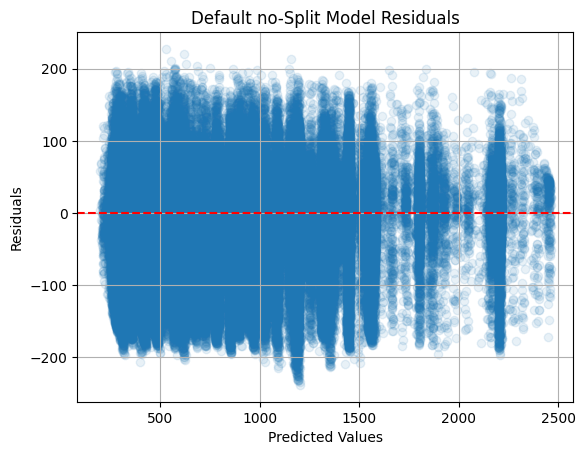

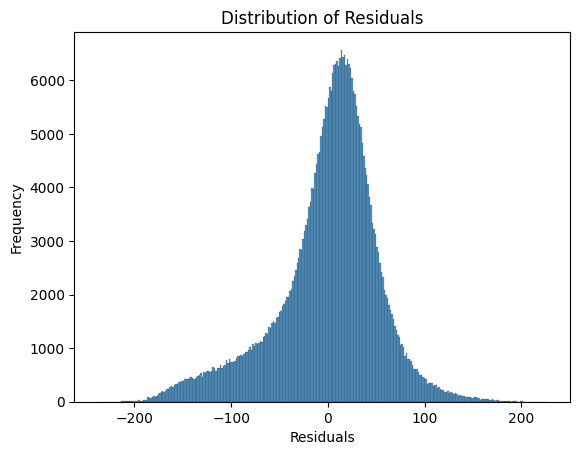

Processing time: 28.17


In [14]:
# Performance measurement
start_time = time.time()

# Define features and target
y = df["REALIZED_TURNOVER_TIME"]
X = df[["CUM_DISTANCE_M", "STATION", "COMBINE", "SPLIT", "ROLLINGSTOCK_TYPE", "NUMBER_CARRIAGES",
        "HOUR_sin", "HOUR_cos", "DAY_OF_WEEK_sin", "DAY_OF_WEEK_cos", "PLAN_TURNOVER_TIME", "DRIVER_CHANGE",
        "DALUREN"
       ]]

# Initial split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the mode
model = LGBMRegressor(random_state = 1,objective = "regression")

# Define cross-validation strategy
kf = KFold(n_splits=5, shuffle=True, random_state = 1)

# Initialize lists to store metrics for each fold
rmse_scores = []

# Perform cross-validation
for train_index, val_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[val_index]
    y_train, y_test = y.iloc[train_index], y.iloc[val_index]
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    rmse = round(mean_absolute_error(y_test, y_pred), 2)
    
    # Store metrics
    rmse_scores.append(rmse)

# Calculate average metrics
avg_rmse = np.mean(rmse_scores)

#Calculate residuals for ALL folds
y_pred_all = cross_val_predict(model, X, y, cv=kf)

# Calculate residuals
residuals = y - y_pred_all

# Plotting residuals
plt.scatter(y_pred_all, residuals, alpha = 0.1)
plt.title('Default no-Split Model Residuals')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='red', linestyle='--')
plt.grid(True)
plt.show()

# Checking for normality of residuals
sns.histplot(residuals)
plt.title('Distribution of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

# Performance measurement
end_time = time.time()
print("Processing time:", round(end_time - start_time, 2))

In [15]:
print(f"Average MAE: {avg_rmse}")

Average MAE: 39.726


## 3. Splitted Models

First calulate the size of each split

In [19]:
# Calculate the total number of rows in the DataFrame
total_rows = len(df)

# Calculate the number of rows for each split
ldf_600 = len(df.loc[df["REALIZED_TURNOVER_TIME"] <= 600])
ldf_1200 = len(df.loc[(df["REALIZED_TURNOVER_TIME"] > 600) & (df["REALIZED_TURNOVER_TIME"] <= 1200)])
ldf_1800 = len(df.loc[(df["REALIZED_TURNOVER_TIME"] > 1200) & (df["REALIZED_TURNOVER_TIME"] <= 1800)])
ldf_2500 = len(df.loc[df["REALIZED_TURNOVER_TIME"] > 1800])

# Calculate the percentage of the total dataset for each split
percentage_600 = (ldf_600 / total_rows) * 100
percentage_1200 = (ldf_1200 / total_rows) * 100
percentage_1800 = (ldf_1800 / total_rows) * 100
percentage_2500 = (ldf_2500 / total_rows) * 100

# Print the results
print(f"Percentage of rows with REALIZED_TURNOVER_TIME <= 600: {percentage_600:.2f}%")
print(f"Percentage of rows with 600 < REALIZED_TURNOVER_TIME <= 1200: {percentage_1200:.2f}%")
print(f"Percentage of rows with 1200 < REALIZED_TURNOVER_TIME <= 1800: {percentage_1800:.2f}%")
print(f"Percentage of rows with REALIZED_TURNOVER_TIME > 1800: {percentage_2500:.2f}%")

Percentage of rows with REALIZED_TURNOVER_TIME <= 600: 44.52%
Percentage of rows with 600 < REALIZED_TURNOVER_TIME <= 1200: 38.27%
Percentage of rows with 1200 < REALIZED_TURNOVER_TIME <= 1800: 14.88%
Percentage of rows with REALIZED_TURNOVER_TIME > 1800: 2.33%


Then create a model and supplementary plots for each of the splits

Evaluating 600 turnovers...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010721 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 358
[LightGBM] [Info] Number of data points in the train set: 140728, number of used features: 13
[LightGBM] [Info] Start training from score 393.903566
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012506 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 356
[LightGBM] [Info] Number of data points in the train set: 140729, number of used features: 13
[LightGBM] [Info] Start training from score 393.855353
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006858 seconds.
You can set `force_row_wise=true` to remove the over

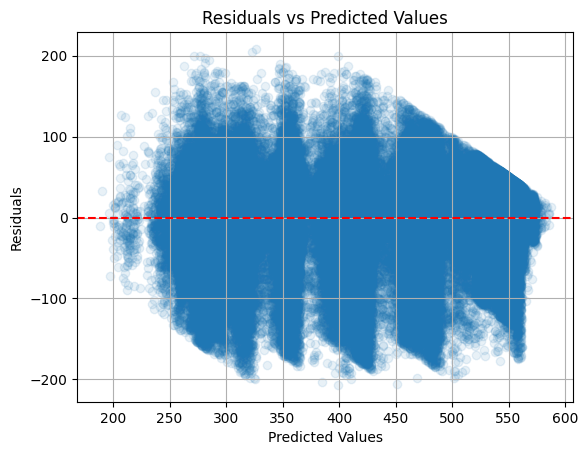

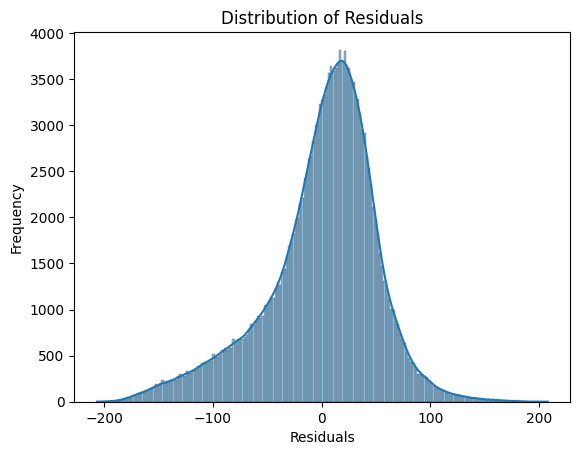

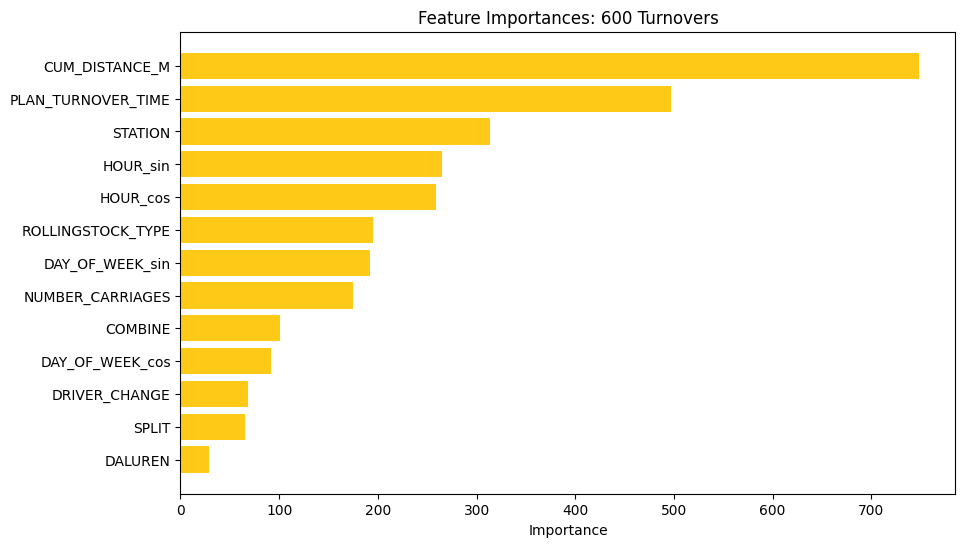

Evaluating 1200 turnovers...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005766 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 406
[LightGBM] [Info] Number of data points in the train set: 120980, number of used features: 13
[LightGBM] [Info] Start training from score 873.233468
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006659 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 399
[LightGBM] [Info] Number of data points in the train set: 120980, number of used features: 13
[LightGBM] [Info] Start training from score 873.852719
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007680 seconds.
You can set `force_row_wise=true` to remove the ove

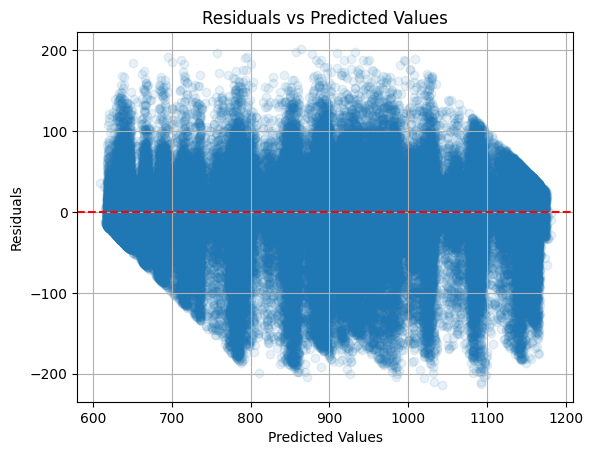

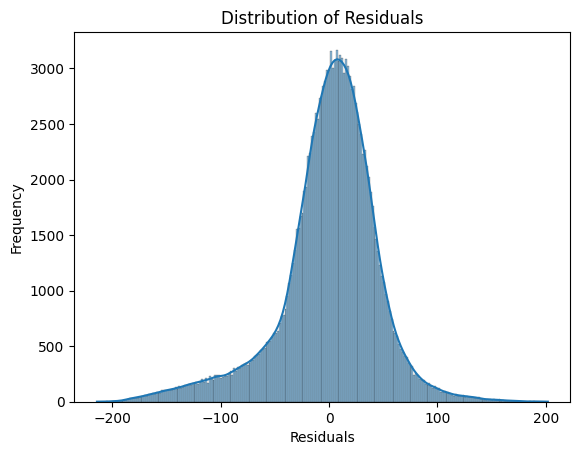

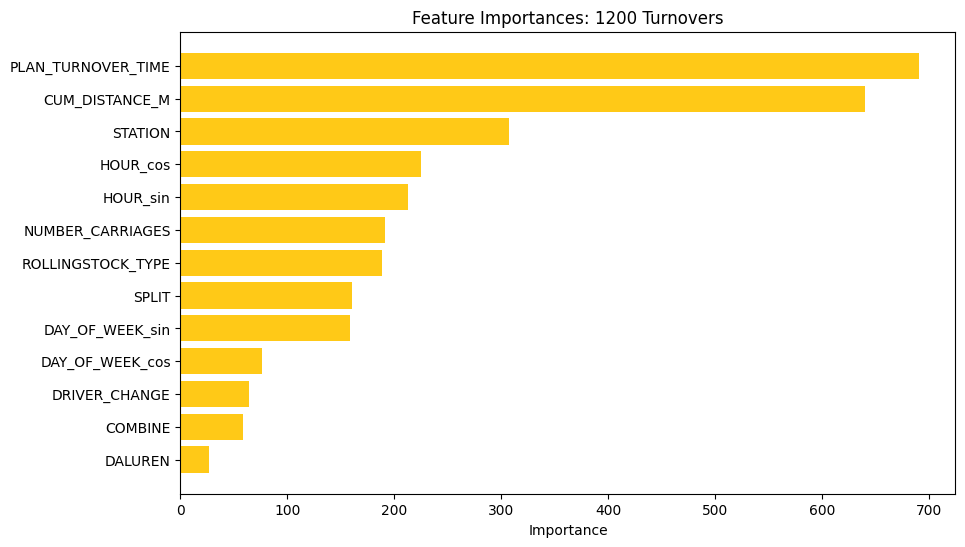

Evaluating 1800 turnovers...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002128 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 333
[LightGBM] [Info] Number of data points in the train set: 47032, number of used features: 13
[LightGBM] [Info] Start training from score 1412.088195
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002080 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 336
[LightGBM] [Info] Number of data points in the train set: 47032, number of used features: 13
[LightGBM] [Info] Start training from score 1412.111988
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003108 seconds.
You can set `force_row_wise=true` to remove the ove

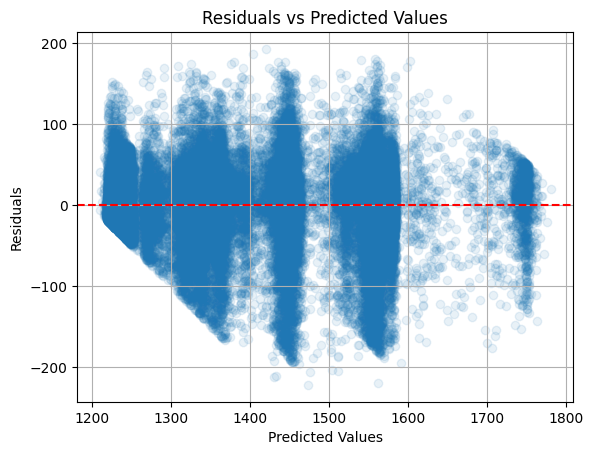

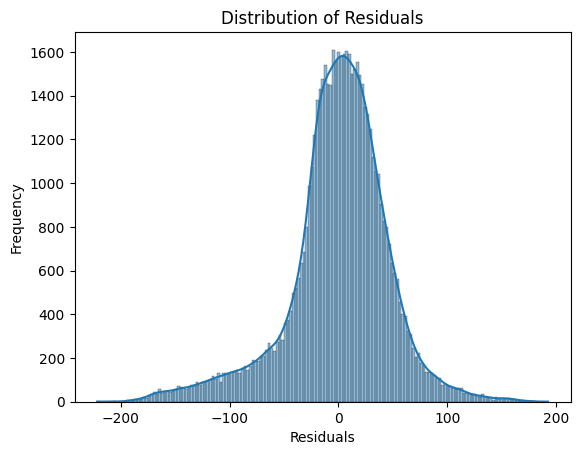

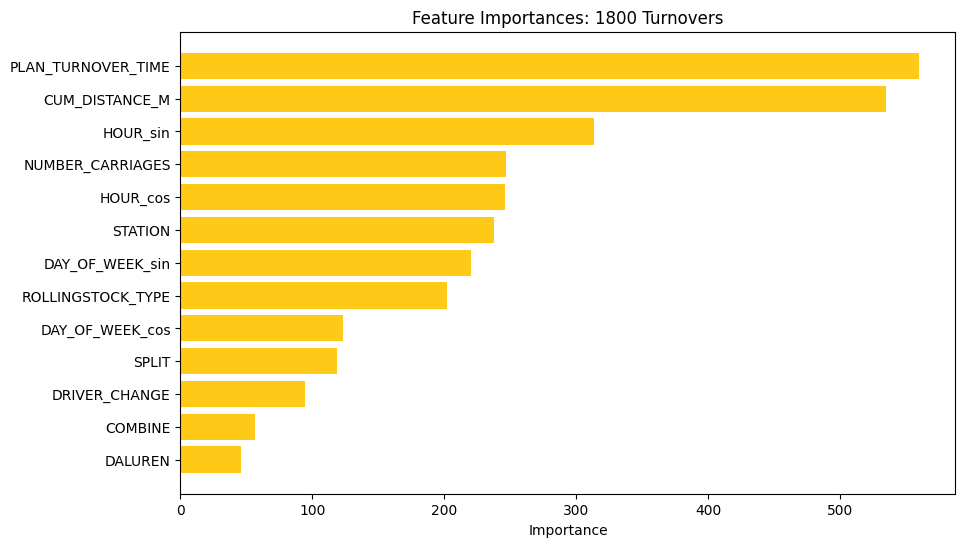

Evaluating 2500 turnovers...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000460 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 7349, number of used features: 13
[LightGBM] [Info] Start training from score 2131.974554
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000436 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 262
[LightGBM] [Info] Number of data points in the train set: 7349, number of used features: 13
[LightGBM] [Info] Start training from score 2130.723364
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000692 seconds.
You can set `force_row_wise=true` to remove the overh

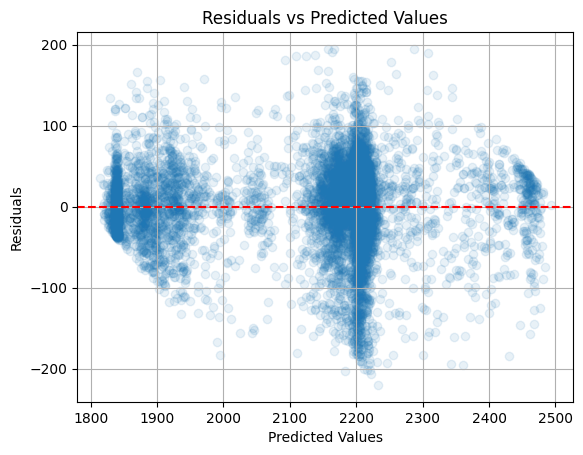

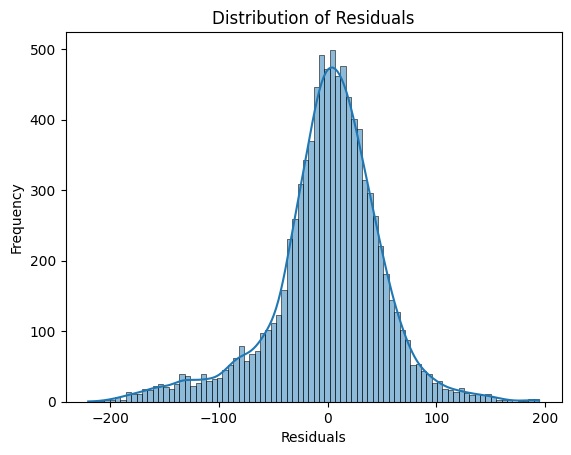

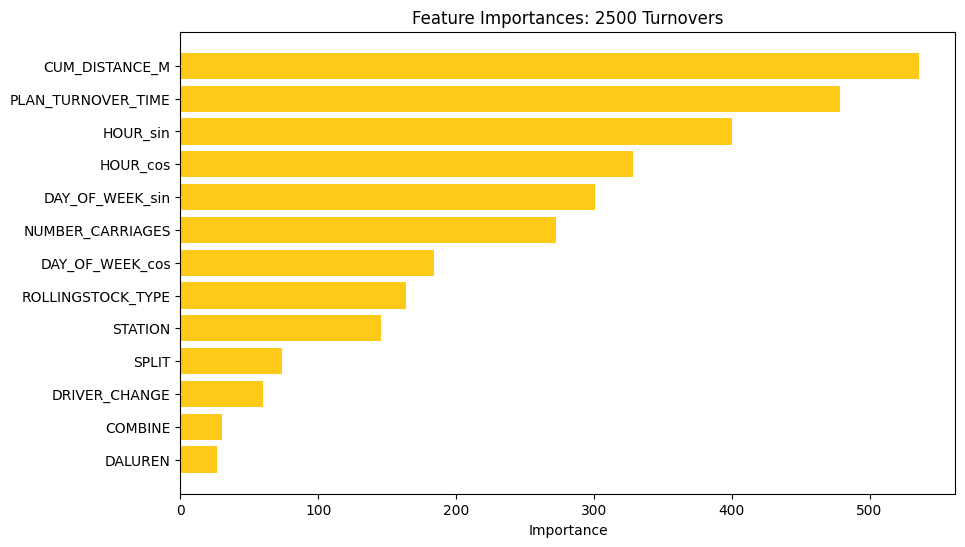

Evaluating all turnovers...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014777 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 460
[LightGBM] [Info] Number of data points in the train set: 316090, number of used features: 13
[LightGBM] [Info] Start training from score 768.605299
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015747 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 462
[LightGBM] [Info] Number of data points in the train set: 316090, number of used features: 13
[LightGBM] [Info] Start training from score 769.067610
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014446 seconds.
You can set `force_row_wise=true` to remove the over

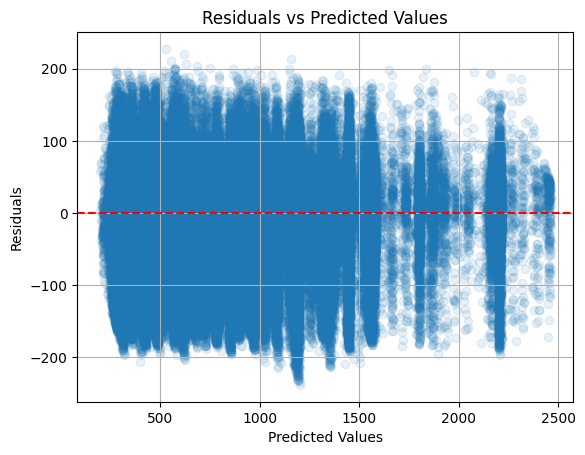

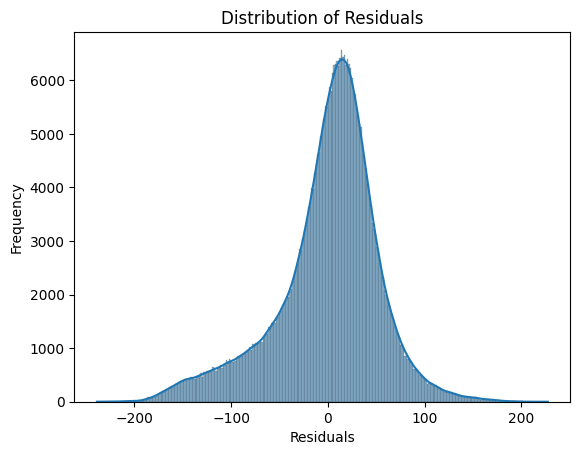

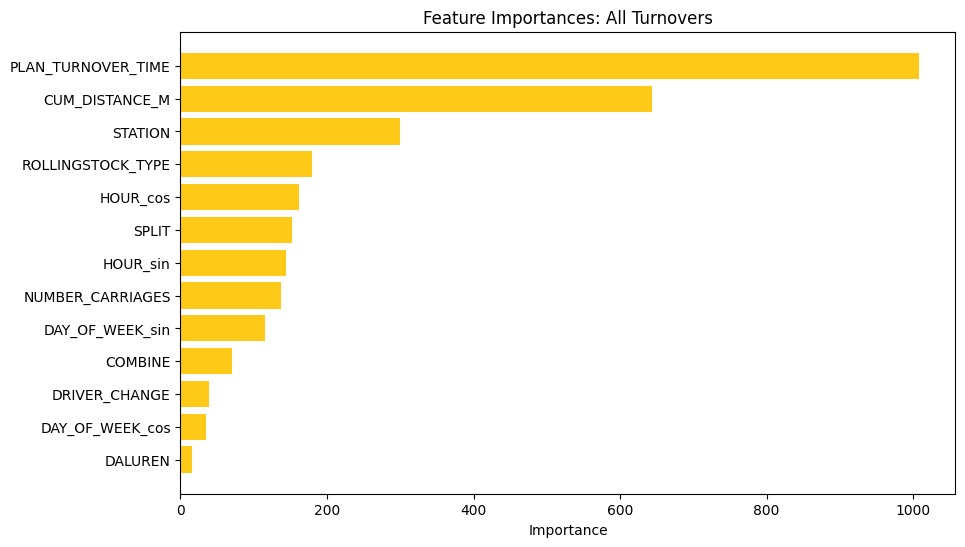

Processing time: 65.72 seconds


In [18]:
df_0_600 = df[df["REALIZED_TURNOVER_TIME"] <= 600]
df_600_1200 = df[(df["REALIZED_TURNOVER_TIME"] > 600) & (df["REALIZED_TURNOVER_TIME"] <= 1200)]
df_1200_1800 = df[(df["REALIZED_TURNOVER_TIME"] > 1200) & (df["REALIZED_TURNOVER_TIME"] <= 1800)]
df_1800_2500 = df[df["REALIZED_TURNOVER_TIME"] > 1800]

def evaluate_model(df, features, target):
    y = df[target]
    X = df[features]

    kf = KFold(n_splits=5, shuffle=True, random_state=1)
    model = LGBMRegressor(random_state=1)

    mae_scores = []
    feature_importances = []

    for train_index, val_index in kf.split(X):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)

        mae = round(np.sqrt(mean_squared_error(y_val, y_pred)), 2)
        mae_scores.append(mae)

        feature_importances.append(model.feature_importances_)

    avg_mae = np.mean(mae_scores)
    y_pred_all = cross_val_predict(model, X, y, cv=kf)
    residuals = y - y_pred_all

    avg_feature_importances = np.mean(feature_importances, axis=0)
    feature_importance_dict = dict(zip(features, avg_feature_importances))

    print(f"Average MAE: {avg_mae}")
    
    plt.figure()
    plt.scatter(y_pred_all, residuals, alpha = 0.1)
    plt.title("4-Split Model Residuals")
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.axhline(y=0, color='red', linestyle='--')
    plt.grid(True)
    plt.title('Residuals vs Predicted Values')
    plt.show()

    plt.figure()
    sns.histplot(residuals, kde=True)
    plt.title('Distribution of Residuals')
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')
    plt.show()

    return avg_mae, feature_importance_dict

def plot_feature_importances(feature_importance_dict, title):
    sorted_importances = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)
    features = [item[0] for item in sorted_importances]
    importances = [item[1] for item in sorted_importances]
    
    plt.figure(figsize=(10, 6))
    plt.barh(features, importances, color= "#FFC917")
    plt.xlabel('Importance')
    plt.title(f'Feature Importances: {title}')
    plt.gca().invert_yaxis()
    plt.show()

start_time = time.time()

# Define features and target
features = ["CUM_DISTANCE_M", "STATION", "COMBINE", "SPLIT", "ROLLINGSTOCK_TYPE", "NUMBER_CARRIAGES",
            "HOUR_sin", "HOUR_cos", "DAY_OF_WEEK_sin", "DAY_OF_WEEK_cos", "PLAN_TURNOVER_TIME", 
            "DRIVER_CHANGE", "DALUREN"
           ]
target = "REALIZED_TURNOVER_TIME"

print("Evaluating 600 turnovers...")
rmse_600, fi_600 = evaluate_model(df_0_600, features, target)
plot_feature_importances(fi_600, '600 Turnovers')

print("Evaluating 1200 turnovers...")
rmse_1200, fi_1200 = evaluate_model(df_600_1200, features, target)
plot_feature_importances(fi_1200, '1200 Turnovers')

print("Evaluating 1800 turnovers...")
rmse_1800, fi_1800 = evaluate_model(df_1200_1800, features, target)
plot_feature_importances(fi_1800, '1800 Turnovers')

print("Evaluating 2500 turnovers...")
rmse_2500, fi_2500 = evaluate_model(df_1800_2500, features, target)
plot_feature_importances(fi_2500, '2500 Turnovers')

print("Evaluating all turnovers...")
rmse_no_split, fi_no_split = evaluate_model(df, features, target)
plot_feature_importances(fi_no_split, 'All Turnovers')

end_time = time.time()
print("Processing time:", round(end_time - start_time, 2), "seconds")

# Save feature importances
feature_importances_all = {
    "600_turnovers": fi_600,
    "1200_turnovers": fi_1200,
    "1800_turnovers": fi_1800,
    "2500_turnovers": fi_2500,
    "all_turnovers": fi_no_split
}

with open("feature_importances.json", "w") as f:
    json.dump(feature_importances_all, f, indent=4)


Combine metrics of each split back into 1 metric using the function below 

In [17]:
def combine_metrics(short_metric, mid_metric, mid2_metric, long_metric, df):
    full_df = len(df) 
    df_600 = len(df.loc[df["REALIZED_TURNOVER_TIME"] <= 600])
    df_1200 = len(df.loc[(df["REALIZED_TURNOVER_TIME"] > 600) & (df["REALIZED_TURNOVER_TIME"] <= 1200) ])
    df_1800 = len(df.loc[(df["REALIZED_TURNOVER_TIME"] > 1200) & (df["REALIZED_TURNOVER_TIME"] <= 1800) ])
    df_2500 = len(df.loc[df["REALIZED_TURNOVER_TIME"] > 1800])
    weighted_metric = ((df_600/full_df) * short_metric + (df_1200/full_df) * mid_metric + (df_1800/full_df) * mid2_metric + (df_2500/full_df) * long_metric)
    return round(weighted_metric, 2)

print(f"MAE (600): {rmse_600}")
print(f"MAE (1200): {rmse_1200}")
print(f"MAE (1800): {rmse_1800}")
print(f"MAE (2500): {rmse_2500}")

print()

# Combined rmse scores
rmse_combined = combine_metrics(rmse_600,rmse_1200, rmse_1800, rmse_2500, df)
print(f"MAE (no split): {rmse_no_split}")
print(f"MAE (four split): {rmse_combined}")

MAE (600): 51.134
MAE (1200): 45.696
MAE (1800): 46.608
MAE (2500): 50.838

MAE (no split): 53.465999999999994
MAE (three split): 48.37
